In [1]:
#| default_exp main
from nbdev import *
from utilities.ipynb_docgen import *
import pandas as pd
import matplotlib.pyplot as plt
!date

Mon Jun 19 10:10:27 PDT 2023


In [2]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wtlike.bayesian import get_bb_partition
from wtlike.lightcurve import fit_cells, LightCurve, flux_plot
from wtlike.cell_data import partition_cells
from wtlike.config import *


class WtLike(LightCurve):
    """
    Initialization
    --------------
    There are three layers of initialization, implemented in superclasses,
    each with parameters. The classnames, associated parameters and data members set:

    SourceData -- load photons and exposure
        parameters:
          - source : name, a PointSource object, or a Simulation object
          - config [Config()] : basic configuration
          - week_range [None] : range of weeks to load
          - key [''] : the cache key: '' means construct one with the source name, None to disable
          - clear [False] : if using cache, clear the contents first
        sets:
          - photons
          - exposure

    CellData -- create cells
        parameters:
          - time_bins [Config().time_bins] : binning: start, stop, binsize
        sets:
          - cells
        creates copies with new cells:
          - view
          - phase_view

    LightCurve -- likelihood analysis of the cells
        parameters:
          - e_min [10] -- threshold for exposure (cm^2 units)
          - n_min [2]  -- likelihood has trouble with this few
          - lc_key [None] -- possible cache for light curve
        sets:
          - fits, fluxes

    WtLike (this class) -- no parameters (may add BB-specific ones)
        Implements:  bb_view, plot_BB
        sets:
          - bb_flux  (only if bb_view invoked)

    """
    def bb_view(self, p0=0.05, key=None, clear=False):
        """Return a view with the BB analysis applied

        - p0 -- false positive probability parameter

        Its `plot` function will by default show an overplot on the parent's data points.
        """
        #  a new instance
        r = self.view()

        # bb analysis on this to make new  set of cells and poisson fits
        bb_edges  = get_bb_partition(self.config, self.fits,  p0=p0, key=key, clear=clear)
        r.cells = partition_cells(self.config, self.cells, bb_edges)

        r.fits = fit_cells(self.config, r.cells, )
        r.isBB = True
        r.bayes_p0 = p0
        return r

    def plot(self, *pars, **kwargs):
        # which view type is this?
        if getattr(self, 'isBB', False):
            return self.plot_bb(*pars, **kwargs)
        elif getattr(self, 'is_phase', False):
            return self.plot_phase(*pars, **kwargs)
        else:
            return super().plot(*pars, **kwargs)

    def plot_bb(self, ax=None, **kwargs):
        """Plot the light curve with BB overplot
        """
        import matplotlib.pyplot as plt
        self.check_plot_kwargs(kwargs)
        figsize = kwargs.pop('figsize', (12,4))
        fignum = kwargs.pop('fignum', 1)
        ts_min = kwargs.pop('ts_min',-1)
        source_name =kwargs.pop('source_name', self.source_name)
        fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)


        colors = kwargs.pop('colors', ('lightblue', 'wheat', 'blue') )
        flux_plot(self.parent.fits, ax=ax, colors=colors, source_name=source_name,
                  label=self.step_name+' bins', **kwargs)
        flux_plot(self.fits, ax=ax, step=True,
                  label=f'BB (p0={100*self.bayes_p0:.0f}%)', zorder=10,**kwargs)
        ax.grid(alpha=0.5)
        fig.set_facecolor('white')
        return fig

    def plot_phase(self, ax=None, **kwargs):
        """Plot a phase lightcurve

        """
        kw = dict(ylim=(0.975, 1.025), xlim=(0,1) )
        kw.update(kwargs)
        fig, ax = plt.subplots(figsize=(10,5)) if ax is None else (ax.figure, ax)
        super().plot( ax=ax, 
                label='', 
                xlabel=f'Phase for {self.period:.4f}-day period',
                source_name='',
                legend_loc='none',
                #colors=('blue','blue','blue'),
                )
        ax.set(**kwargs )
        ax.axhline(1.0, color='grey', ls=':')
        return fig

    def reweighted_view(self, other):
        """
        Return a view in which the weights have been modifed to account for a variable neighbor

        * other -- the WtLike BB view of the neighbor.
        """
        import copy
        assert getattr(other, 'isBB', False), 'Expected a bb_view'
        r = copy.copy(self)
        r.parent = self
        r.photons = photons = self.photons.copy()

        def get_w2():
            nborwtman = other.source.wtman
            mod_photons = nborwtman.add_weights(photons.copy())
            return mod_photons.weight

        def get_alpha2():
            bbf = other.fluxes
            t,tw = bbf.t.values, bbf.tw.values
            bb_edges = np.append(t-tw/2, t[-1]+tw[-1]/2)
            ssi = np.searchsorted(bb_edges, photons.time)
            # isert nans at both ends of bb blux
            bbflux = np.append(np.insert(bbf.flux.values, 0, np.nan), np.nan)
            # limit values of alphas for safety
            return (bbflux[ssi]-1).clip(0,1)

        def wprime(row):
            """ Apply
            $$w'_1 = \frac{w_1}{1+\alpha_2\ w_2}\ \    $$
            """
            w1 = row['weight']
            a2 = row['alpha2']
            w2 = row['w2']
            return w1/(1+a2*w2)

        # alpha2 = get_alpha2()
        # w2 = get_w2()

        r.photons.loc[:,'w2'] = get_w2().astype(np.float32)
        r.photons.loc[:,'alpha2'] = get_alpha2().astype(np.float32)

        def fix_weights(df):
            """ return modified weights """
            w1 = df.weight
            w2 = df.w2
            a2 = df.alpha2
            return np.where( np.isnan(w2) | np.isnan(a2),
                           w1,
                           w1/(1+a2*w2) )

        #photons.loc[:,'oldw'] = photons.weight
        r.photons.loc[:,'weight'] = fix_weights(photons).astype(np.float32)

        # new weights, so must rebin, then fit them
        r.rebin(self.time_bins)
        r.update()

        return r

### Demonstrate the phase_view with Vela and Geminga

This uses the `phase_view` function to generate a view with cells that are folded according 
to the specified period, relative to UTC 2008.
<details  class="nbdoc-description" >  <summary> Vela setup, 53.05-day period </summary>  <div style="margin-left: 25px;"><pre>SourceData:  PSR J0835-4510: Saving to cache with key "PSR J0835-4510_data"<br>	Processing 771 week files week_009.pkl - week_780.pkl , using 4 processes <br><br>SourceData: Source Vela pulsar with:<br>	 data:     3,878,399 photons from 2008-08-04 to 2023-05-14<br>	 exposure: 3,531,370 intervals,  average effective area 3463 cm^2 for 105.5 Ms<br>	 rates:  source 8.53e-06/s, background 2.08e-06/s, TS 7689321.2<br>CellData.rebin: Bin photon data into 770 1-week bins from 54683.0 to 60073.0<br>LightCurve: select 762 cells for fitting with e&gt;35.000 & n&gt;2<br>CellData.phase_view: Create phase view, 25 bins with period 53.05 days.<br>CellData.rebin: Bin photon data into 2542 2.1-day bins from 54684.6 to 60078.7<br>LightCurve: select 25 cells for fitting with e&gt;10.610 & n&gt;2<br></pre></div> </details>    
<details  class="nbdoc-description" >  <summary> Geminga setup: 365.25-day period </summary>  <div style="margin-left: 25px;"><pre>SourceData:  PSR J0633+1746: Saving to cache with key "PSR J0633+1746_data"<br>	Processing 771 week files week_009.pkl - week_780.pkl , using 4 processes <br><br>SourceData: Source Geminga with:<br>	 data:     1,270,764 photons from 2008-08-04 to 2023-05-14<br>	 exposure: 3,571,962 intervals,  average effective area 2690 cm^2 for 106.8 Ms<br>	 rates:  source 3.27e-06/s, background 1.15e-06/s, TS 2589330.0<br>CellData.rebin: Bin photon data into 770 1-week bins from 54683.0 to 60073.0<br>LightCurve: select 749 cells for fitting with e&gt;35.000 & n&gt;2<br>CellData.phase_view: Create phase view, 50 bins with period 365.25 days.<br>CellData.rebin: Bin photon data into 738 7.3-day bins from 54685.2 to 60076.2<br>LightCurve: select 50 cells for fitting with e&gt;36.525 & n&gt;2<br></pre></div> </details>
<div style="margin-left: 10px"><figure style="margin-left: 10px" >   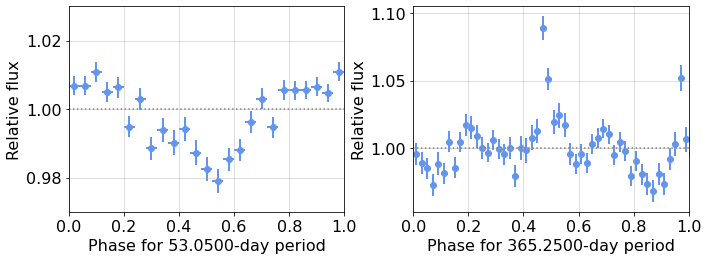 <br> </figure></div>


In [3]:
#| code-fold: true
@ipynb_doc
def phase_demo():
    """
    ### Demonstrate the phase_view with Vela and Geminga
    
    This uses the `phase_view` function to generate a view with cells that are folded according 
    to the specified period, relative to UTC {ref_date}.
    {out1}    
    {out2}
    {thefig}
    """
    plt.rc('font', size=16)
    year = 365.25; ref_date='2008'; precess=53.05

    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5)) # sharey=True)
    plt.subplots_adjust(wspace=0.25)
    thefig = figure(fig, width=800)
    
    with capture(f'Vela setup, {precess}-day period') as out1:
        vela = WtLike('Vela pulsar')
        pv = vela.phase_view( period=precess, nbins=25); 
    pv.plot(ax=ax1, xlim=(0,1), ylim=(0.97,1.03))

    with capture(f'Geminga setup: {year}-day period') as out2:
        geminga = WtLike('Geminga')
        gv = geminga.phase_view(year, nbins=50, reference=ref_date)
    gv.plot(ax=ax2, xlim=(0,1))    

    return locals()

if Config().valid:
    phase_demo()

In [4]:
show_doc(WtLike)
show_doc(WtLike.bb_view)
show_doc(WtLike.phase_view)
show_doc(WtLike.reweighted_view)

/home/burnett/miniconda3/lib/python3.10/site-packages/fastcore/docscrape.py:225: UserWarning: Unknown section Initialization
  else: warn(msg)


---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/main.py#L124){target="_blank" style="float:right; font-size:smaller"}

### WtLike.reweighted_view

>      WtLike.reweighted_view (other)

Return a view in which the weights have been modifed to account for a variable neighbor

* other -- the WtLike BB view of the neighbor.

## Test/Demonstration with 3C 279

> Note that this also demonstrates using the `ipynb_doc` decorator to have a single Jupyterlab cell generate a document

<details  class="nbdoc-description" >  <summary> Setup 3C 279 </summary>  <div style="margin-left: 25px;"><pre>SourceData:  3C 279: Restoring from cache with key "P88Y3243_data"<br>SourceData: Source 3C 279 with:<br>	 data:       197,399 photons from 2008-08-04 to 2023-05-14<br>	 exposure: 3,244,224 intervals,  average effective area 2767 cm^2 for 96.9 Ms<br>	 rates:  source 3.78e-07/s, background 3.58e-07/s, TS 211203.7<br>CellData.rebin: Bin photon data into 770 1-week bins from 54683.0 to 60073.0<br>LightCurve: select 756 cells for fitting with e&gt;35.000 & n&gt;2<br></pre></div> </details>
First, the weekly light curve:
<div style="margin-left: 10px"><figure style="margin-left: 10px" >   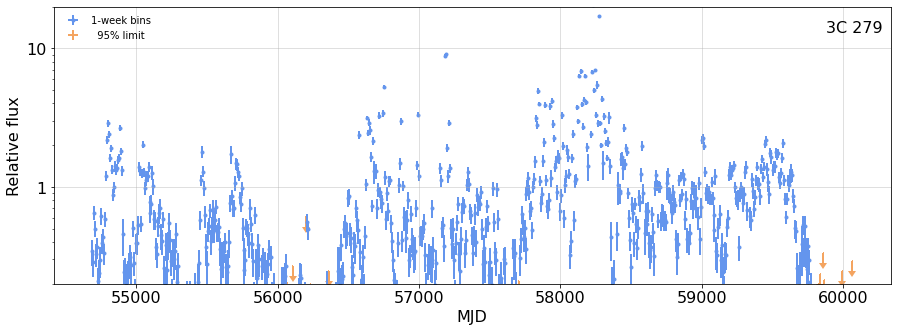 <br>  <figcaption>Full scale</figcaption></figure></div>

Replot the figure with an expanded scale to see position of a flare:
<div style="margin-left: 10px"><figure style="margin-left: 10px" >   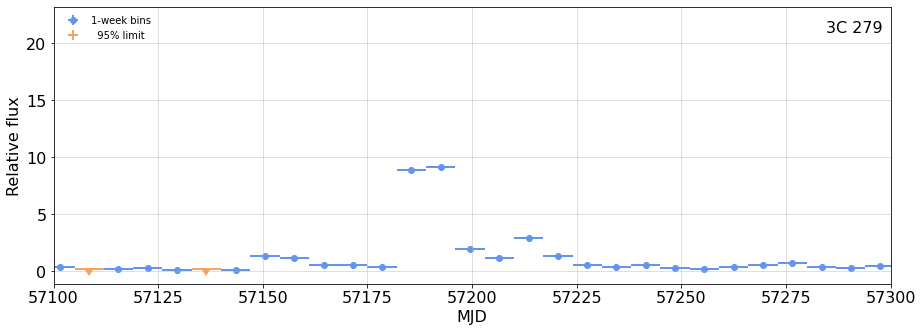 <br> </figure></div>
<details  class="nbdoc-description" >  <summary> Define orbit-based subset around large flare at MJD 57189 </summary>  <div style="margin-left: 25px;"><pre>CellData.rebin: Bin photon data into 80 orbit-based bins from 57186.1 to 57191.0<br>LightCurve: select 62 cells for fitting with e&gt;0.000 & n&gt;2<br></pre></div> </details>    <div style="margin-left: 10px"><figure style="margin-left: 10px" >   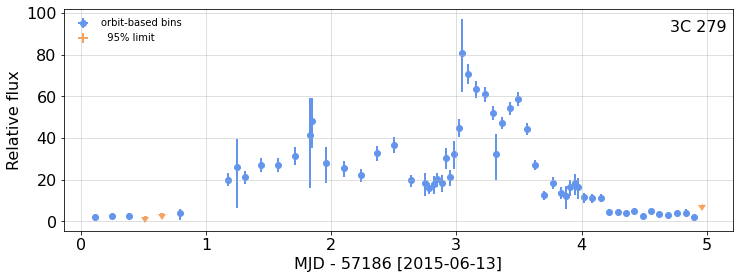 <br> </figure></div>
<details  class="nbdoc-description" >  <summary> Apply BB and overplot it with the cells on which it is based </summary>  <div style="margin-left: 25px;"><pre>Bayesian Blocks: partitioning 62 cells using LikelihoodFitness with penalty 5%<br>	found 10 / 62 blocks.<br>LightCurve: Loaded 10 / 10 cells for fitting<br></pre></div> </details>    <div style="margin-left: 10px"><figure style="margin-left: 10px" >   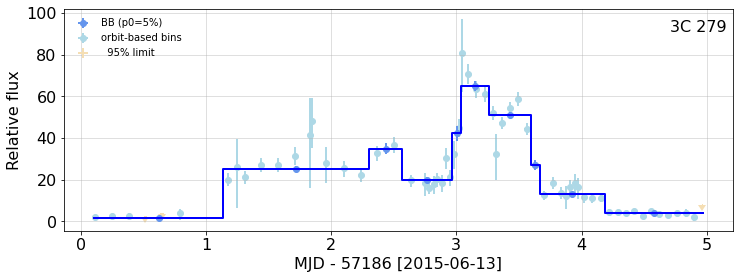 <br> </figure></div>

Table of BB fits
<div style="margin-left: 25px"><table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>t</th>
      <th>tw</th>
      <th>n</th>
      <th>e</th>
      <th>ts</th>
      <th>flux</th>
      <th>errors</th>
      <th>limit</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>57186.116</td>
      <td>0.017</td>
      <td>5</td>
      <td>4.449</td>
      <td>13.700</td>
      <td>1.980</td>
      <td>(-0.961, 1.389)</td>
      <td>5.116</td>
    </tr>
    <tr>
      <td>57186.253</td>
      <td>0.025</td>
      <td>9</td>
      <td>6.358</td>
      <td>13.300</td>
      <td>2.573</td>
      <td>(-1.039, 1.335)</td>
      <td>5.315</td>
    </tr>
    <tr>
      <td>57186.385</td>
      <td>0.026</td>
      <td>9</td>
      <td>6.391</td>
      <td>16.500</td>
      <td>2.817</td>
      <td>(-1.066, 1.353)</td>
      <td>5.570</td>
    </tr>
    <tr>
      <td>57186.517</td>
      <td>0.026</td>
      <td>3</td>
      <td>6.326</td>
      <td>0.000</td>
      <td>0.000</td>
      <td>(0, 0.791)</td>
      <td>2.155</td>
    </tr>
    <tr>
      <td>57186.650</td>
      <td>0.026</td>
      <td>5</td>
      <td>6.311</td>
      <td>3.400</td>
      <td>1.206</td>
      <td>(-0.759, 1.05)</td>
      <td>3.506</td>
    </tr>
    <tr>
      <td>57186.791</td>
      <td>0.009</td>
      <td>4</td>
      <td>1.828</td>
      <td>8.100</td>
      <td>3.929</td>
      <td>(-2.121, 3.172)</td>
      <td>11.274</td>
    </tr>
    <tr>
      <td>57187.177</td>
      <td>0.021</td>
      <td>46</td>
      <td>5.783</td>
      <td>288.900</td>
      <td>20.083</td>
      <td>(-2.944, 3.248)</td>
      <td>25.930</td>
    </tr>
    <tr>
      <td>57187.245</td>
      <td>0.003</td>
      <td>3</td>
      <td>0.277</td>
      <td>11.900</td>
      <td>26.021</td>
      <td>(-13.299, 19.736)</td>
      <td>71.464</td>
    </tr>
    <tr>
      <td>57187.312</td>
      <td>0.027</td>
      <td>56</td>
      <td>6.740</td>
      <td>366.400</td>
      <td>21.238</td>
      <td>(-2.804, 3.065)</td>
      <td>26.710</td>
    </tr>
    <tr>
      <td>57187.444</td>
      <td>0.027</td>
      <td>71</td>
      <td>6.664</td>
      <td>507.000</td>
      <td>27.224</td>
      <td>(-3.208, 3.472)</td>
      <td>33.366</td>
    </tr>
    <tr>
      <td>57187.576</td>
      <td>0.027</td>
      <td>70</td>
      <td>6.608</td>
      <td>477.000</td>
      <td>27.089</td>
      <td>(-3.213, 3.479)</td>
      <td>33.247</td>
    </tr>
    <tr>
      <td>57187.714</td>
      <td>0.017</td>
      <td>54</td>
      <td>4.401</td>
      <td>366.000</td>
      <td>31.497</td>
      <td>(-4.214, 4.614)</td>
      <td>39.746</td>
    </tr>
    <tr>
      <td>57187.829</td>
      <td>0.002</td>
      <td>4</td>
      <td>0.246</td>
      <td>22.900</td>
      <td>41.222</td>
      <td>(-18.036, 25.227)</td>
      <td>96.735</td>
    </tr>
    <tr>
      <td>57187.852</td>
      <td>0.006</td>
      <td>17</td>
      <td>0.905</td>
      <td>131.800</td>
      <td>48.286</td>
      <td>(-11.073, 13.016)</td>
      <td>73.073</td>
    </tr>
    <tr>
      <td>57187.963</td>
      <td>0.006</td>
      <td>12</td>
      <td>1.063</td>
      <td>64.700</td>
      <td>27.854</td>
      <td>(-7.77, 9.44)</td>
      <td>46.353</td>
    </tr>
    <tr>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
      <td>...</td>
    </tr>
    <tr>
      <td>57190.016</td>
      <td>0.013</td>
      <td>23</td>
      <td>4.987</td>
      <td>120.600</td>
      <td>11.503</td>
      <td>(-2.365, 2.717)</td>
      <td>16.576</td>
    </tr>
    <tr>
      <td>57190.085</td>
      <td>0.016</td>
      <td>29</td>
      <td>6.470</td>
      <td>162.000</td>
      <td>11.271</td>
      <td>(-2.064, 2.336)</td>
      <td>15.573</td>
    </tr>
    <tr>
      <td>57190.153</td>
      <td>0.021</td>
      <td>40</td>
      <td>8.602</td>
      <td>188.000</td>
      <td>11.383</td>
      <td>(-1.835, 2.039)</td>
      <td>15.076</td>
    </tr>
    <tr>
      <td>57190.221</td>
      <td>0.024</td>
      <td>20</td>
      <td>9.648</td>
      <td>56.200</td>
      <td>4.627</td>
      <td>(-1.118, 1.304)</td>
      <td>7.094</td>
    </tr>
    <tr>
      <td>57190.291</td>
      <td>0.033</td>
      <td>26</td>
      <td>13.047</td>
      <td>83.900</td>
      <td>4.543</td>
      <td>(-0.96, 1.094)</td>
      <td>6.571</td>
    </tr>
    <tr>
      <td>57190.358</td>
      <td>0.032</td>
      <td>24</td>
      <td>12.731</td>
      <td>80.000</td>
      <td>4.102</td>
      <td>(-0.925, 1.059)</td>
      <td>6.074</td>
    </tr>
    <tr>
      <td>57190.423</td>
      <td>0.033</td>
      <td>29</td>
      <td>12.853</td>
      <td>96.900</td>
      <td>5.141</td>
      <td>(-1.027, 1.163)</td>
      <td>7.283</td>
    </tr>
    <tr>
      <td>57190.490</td>
      <td>0.032</td>
      <td>17</td>
      <td>12.598</td>
      <td>45.400</td>
      <td>2.735</td>
      <td>(-0.754, 0.9)</td>
      <td>4.471</td>
    </tr>
    <tr>
      <td>57190.555</td>
      <td>0.033</td>
      <td>30</td>
      <td>12.783</td>
      <td>91.700</td>
      <td>5.150</td>
      <td>(-1.039, 1.174)</td>
      <td>7.308</td>
    </tr>
    <tr>
      <td>57190.622</td>
      <td>0.032</td>
      <td>20</td>
      <td>12.530</td>
      <td>67.100</td>
      <td>3.373</td>
      <td>(-0.845, 0.991)</td>
      <td>5.256</td>
    </tr>
    <tr>
      <td>57190.694</td>
      <td>0.020</td>
      <td>11</td>
      <td>7.773</td>
      <td>28.700</td>
      <td>3.053</td>
      <td>(-0.984, 1.218)</td>
      <td>5.477</td>
    </tr>
    <tr>
      <td>57190.763</td>
      <td>0.016</td>
      <td>11</td>
      <td>6.325</td>
      <td>40.600</td>
      <td>3.995</td>
      <td>(-1.237, 1.519)</td>
      <td>7.002</td>
    </tr>
    <tr>
      <td>57190.831</td>
      <td>0.012</td>
      <td>9</td>
      <td>4.501</td>
      <td>26.700</td>
      <td>4.279</td>
      <td>(-1.505, 1.91)</td>
      <td>8.164</td>
    </tr>
    <tr>
      <td>57190.898</td>
      <td>0.009</td>
      <td>3</td>
      <td>3.350</td>
      <td>6.400</td>
      <td>1.988</td>
      <td>(-1.106, 1.636)</td>
      <td>5.746</td>
    </tr>
    <tr>
      <td>57190.966</td>
      <td>0.006</td>
      <td>3</td>
      <td>2.138</td>
      <td>2.000</td>
      <td>2.053</td>
      <td>(-1.605, 2.473)</td>
      <td>7.957</td>
    </tr>
  </tbody>
</table></div>

This can be compared with Figure 4 from the [Kerr paper](https://arxiv.org/pdf/1910.00140.pdf)
<div style="margin-left: 10px"><figure style="margin-left: 10px" >   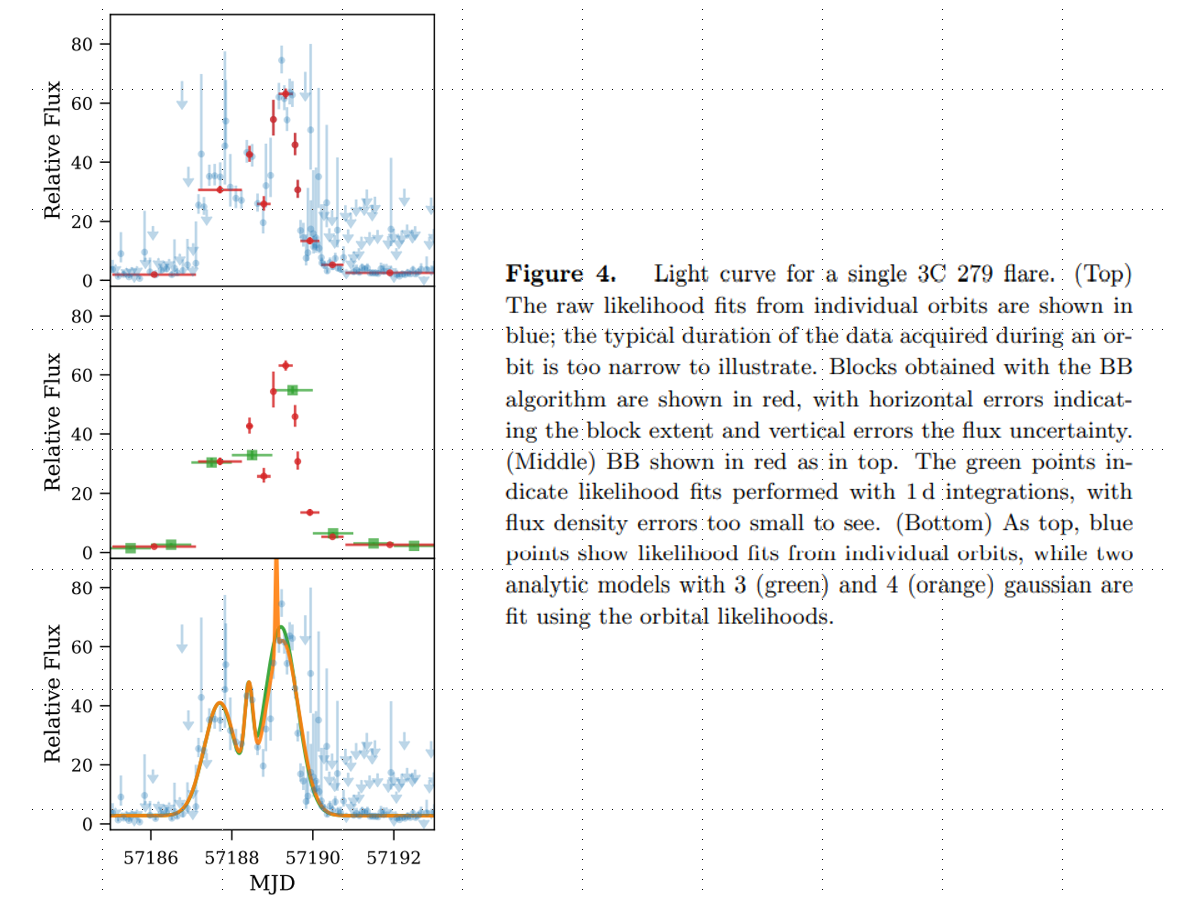 <br> </figure></div>


In [5]:
#| code-fold: true
full = None
# code for the demo--this shouid be collapsed
@ipynb_doc
def wtlike_demo(clear=False):
    """
    ## Test/Demonstration with 3C 279
    
    > Note that this also demonstrates using the `ipynb_doc` decorator to have a single Jupyterlab cell generate a document
    
    {out1}
    First, the weekly light curve:
    {fig1}
    
    Replot the figure with an expanded scale to see position of a flare:
    {fig2}
    {out3}    {fig3}
    {out4}    {fig4}
    
    Table of BB fits
    {bb_table}
    
    This can be compared with Figure 4 from the [Kerr paper](https://arxiv.org/pdf/1910.00140.pdf)
    {kerr_fig4}
    """
    global full
    

    with capture('Setup 3C 279') as out1:
        full = WtLike('3C 279', clear=clear)
    
    fig1 = figure(
        full.plot(yscale='log', ylim=(0.2,20), figsize=(15,5), xlabel='MJD', fmt='.', fignum=1),
        caption='Full scale',  )  
    
    fig2 = figure(
        full.plot(  figsize=(15,5), xlabel='MJD', fmt='o', fignum=2,  xlim=(57100, 57300),),
         )  
    
    with capture_hide('Define orbit-based subset around large flare at MJD 57189') as out3:
        orbit = full.view((57186, 57191, 0))
    fig3 = figure(
        orbit.plot(fmt='o', tzero=57186,   fignum=3 ),
             )
    
    with capture_hide('Apply BB and overplot it with the cells on which it is based') as out4:
        bborbit = orbit.bb_view()
    fig4 = figure(
        bborbit.plot(fmt='o', tzero=57186,   fignum=4),
                 )
    
    bb_table = orbit.fluxes
    
    kerr_fig4 = image('kerr_fig4.png', caption=None)
    return locals()

if Config().valid:
    wtlike_demo( False)

In [6]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Mon Jun 19 10:15:19 PDT 2023
